In [1]:
from dotenv import load_dotenv
load_dotenv()

True

Настройки из .env извлекаются не каждый раз

In [2]:
from chatsky_llm_autoconfig.settings import EnvSettings
env_settings = EnvSettings()
env_settings.RERANKER_MODEL

'BAAI/bge-reranker-v2-m3'

In [3]:
from chatsky_llm_autoconfig.algorithms.append_chain import AppendChain
from chatsky_llm_autoconfig.metrics.automatic_metrics import all_utterances_present
from chatsky_llm_autoconfig.graph import BaseGraph, Graph
from chatsky_llm_autoconfig.schemas import DialogueGraph
from chatsky_llm_autoconfig.dialogue import Dialogue, DialogueMessage

/home/olshevskaya/miniconda3/envs/conda_env_py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


### AppendChain on simple data

In [4]:
original_dialogue = Dialogue(messages=[
    # DialogueMessage(text="Hello", participant="user"),
    DialogueMessage(text="Hello, how can I help?", participant="assistant"),
    DialogueMessage(text="I want to take a book", participant="user"),
    DialogueMessage(text="Which author are you interested in?", participant="assistant"),
    DialogueMessage(text="Arseniy Tarkovsky", participant="user"),
    DialogueMessage(text="Here you are", participant="assistant"),
])

additional_dialogue = Dialogue(messages=[
    # DialogueMessage(text="Hello", participant="user"),
    DialogueMessage(text="Hello, how can I help?", participant="assistant"),
    DialogueMessage(text="I want to take a magazine", participant="user"),
    DialogueMessage(text="Which magazine are you interested in?", participant="assistant"),
    DialogueMessage(text="Vogue", participant="user"),
    DialogueMessage(text="Which period are you interested in?", participant="assistant"),
    DialogueMessage(text="October 1987", participant="user"),
    DialogueMessage(text="Here you are", participant="assistant"),
])
list_of_dialogues = [original_dialogue, additional_dialogue]

In [5]:
original_graph = Graph(graph_dict={
    "nodes": [
        {
            "id": 1,
            "label": "start",
            "is_start": True,
            "utterances": [
                "Hello, how can I help?"
            ]
        },
        {
            "id": 2,
            "label": "ask_author",
            "is_start": False,
            "utterances": [
                "Which author are you interested in?"
            ]
        },
        {
            "id": 3,
            "label": "end",
            "is_start": False,
            "utterances": [
                "Here you are"
            ]
        },
    ],
    "edges": [
        {
            "utterances": [
                "I want to take a book"
            ],
            "source": 1,
            "target": 2
        },
        {
            "utterances": [
                "Arseniy Tarkovsky"
            ],
            "source": 2,
            "target": 3
        },
    ]
})

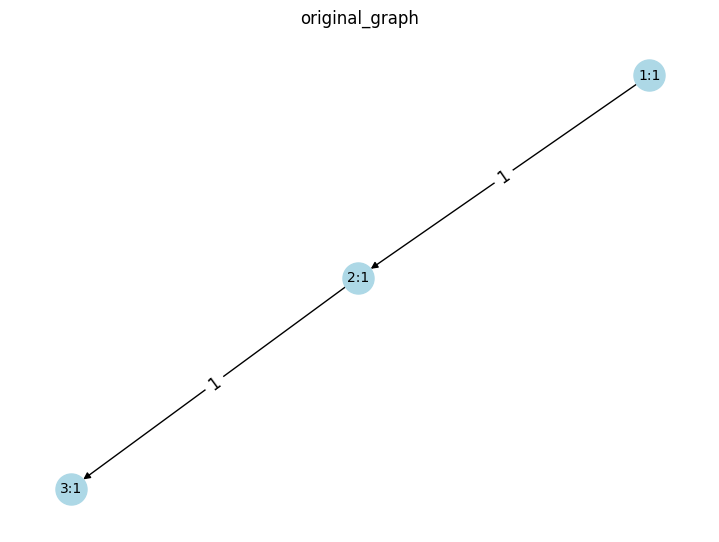

In [23]:
original_graph.visualise_short('original_graph')

In [ ]:
appender = AppendChain()
result = appender.invoke(list_of_dialogues, original_graph)

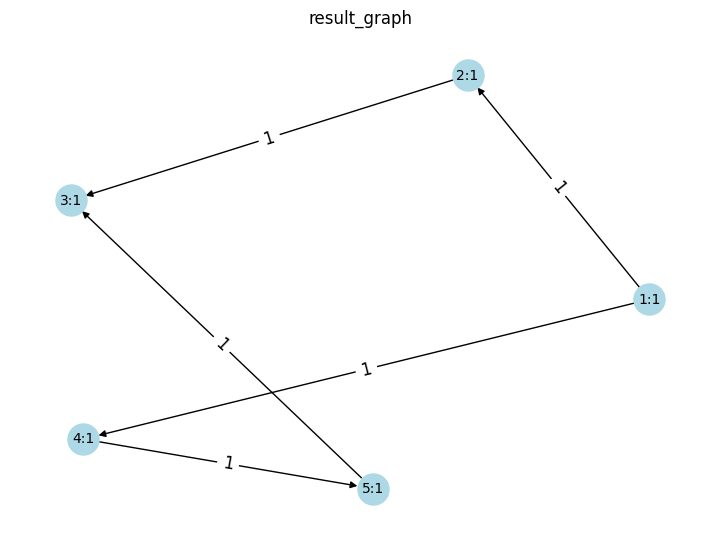

In [22]:
result.visualise_short('result_graph')

In [24]:
all_utterances_present(result, list_of_dialogues)

Graph has all the dialogues


True

In [11]:
from langchain_openai  import ChatOpenAI
from chatsky_llm_autoconfig.metrics.llm_metrics import are_triplets_valid

In [14]:
model = ChatOpenAI(name="gpt-3.5-turbo", temperature=0)

In [30]:
validation_report = are_triplets_valid(result, model)
validation_report

{'value': True, 'description': 'All transitions are valid.'}

### GeneratorI0 on simple data

In [6]:
from chatsky_llm_autoconfig.algorithms.three_stages_0i import ThreeStagesGraphGenerator as GeneratorI0

In [9]:
result_graph_llm = GeneratorI0().invoke([additional_dialogue], original_graph)

model:   gpt-3.5-turbo
LLM
RES:  {'edges': [{'source': 1, 'target': 2, 'utterances': ['I want to take a book']}, {'source': 1, 'target': 2, 'utterances': ['Arseniy Tarkovsky']}, {'source': 1, 'target': 2, 'utterances': ['Vogue']}, {'source': 1, 'target': 2, 'utterances': ['October 1987']}], 'nodes': [{'id': 1, 'label': 'start', 'is_start': True, 'utterances': ['Hello, how can I help?', 'I want to take a magazine', 'Which magazine are you interested in?', 'Which period are you interested in?', 'Here you are']}, {'id': 2, 'label': 'end', 'is_start': False, 'utterances': ['Vogue', 'October 1987']}]}
SKIP


In [15]:
all_utterances_present(result_graph_llm, list_of_dialogues)
val_report = are_triplets_valid(result_graph_llm, model)
print(val_report)

absent:  ('which author are you interested in?', 'arseniy tarkovsky', 'here you are')
absent:  ('which period are you interested in?', 'october 1987', 'here you are')
absent:  ('which magazine are you interested in?', 'vogue', 'which period are you interested in?')
absent:  ('hello, how can i help?', 'i want to take a magazine', 'which magazine are you interested in?')
absent:  ('hello, how can i help?', 'i want to take a book', 'which author are you interested in?')
{'value': False, 'description': "Invalid transition: The user's response 'I want to take a book' does not logically connect to the assistant's next message 'Vogue, October 1987'. The assistant's initial prompt and the user's response do not align in terms of the desired item (magazine vs. book), making the transition feel disjointed. Invalid transition: The user's response 'Arseniy Tarkovsky' does not logically connect to the assistant's next message 'Vogue, October 1987'. There is a disconnect in the conversation flow."}


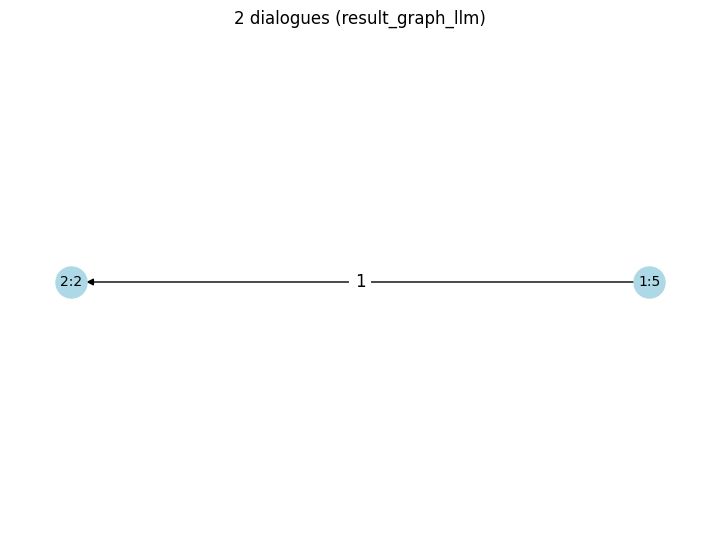

In [16]:
result_graph_llm.visualise_short("2 dialogues (result_graph_llm)")

### AppendChain on dataset example

In [34]:
# import json
# import logging
# import ast
from datasets import load_dataset
%load_ext autoreload
%autoreload 2

from chatsky_llm_autoconfig.algorithms.three_stages_1 import ThreeStagesGraphGenerator as Generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
dataset = load_dataset("GEM/schema_guided_dialog", trust_remote_code=True)

# dialogues about rental cars
new_data=[]
for d in [el for el in dataset['test'] if el['service'] == 'RentalCars_3']:
    exist = [[{'text':"Hello! How can I help you?", "participant":"assistant"}]] + [[{"text":u,"participant":"user"},{"text":a,"participant":"assistant"},] for u,a in zip(d['context'][0:-1:2],d['context'][1::2])] + [[{'text':d['prompt'], "participant":"user"}, {'text':d['target'], "participant":"assistant"}]]
    new_data.append([x for xs in exist for x in xs])

Initializing the first dialogue and its graph

In [43]:
original_dialogue = [Dialogue.from_list(c) for c in new_data[:1]]
original_dialogue

[Dialogue(messages=[DialogueMessage(text='Hello! How can I help you?', participant='assistant'), DialogueMessage(text="I'm having a friend visit and we want some fun attractions to go to, maybe a museum. Can you find one for me?", participant='user'), DialogueMessage(text='In which city should I search in?', participant='assistant'), DialogueMessage(text='Please look for attractions in London, UK.', participant='user'), DialogueMessage(text='I suggest a museum called Apsley House.', participant='assistant'), DialogueMessage(text='Is there anything else? Preferably something child-friendly.', participant='user'), DialogueMessage(text='I suggest a museum called BODY WORLDS London.', participant='assistant'), DialogueMessage(text='Where can I contact them?', participant='user'), DialogueMessage(text='You can contact them at 330 223 3233.', participant='assistant'), DialogueMessage(text='Is there a cost to enter the museum?', participant='user'), DialogueMessage(text='No, it is free to ent

In [44]:
graph_generator = Generator("gpt-3.5-turbo") # To generate 1st graph from one dialogue
original_graph = graph_generator.invoke(original_dialogue)

LLM
Failed to parse DialogueNodes from completion [{"id": 1, "label": "start", "is_start": true, "utterances": ["Hello! How can I help you?"]}, {"id": 2, "label": "find_attractions", "is_start": false, "utterances": ["I'm having a friend visit and we want some fun attractions to go to, maybe a museum. Can you find one for me?"]}, {"id": 3, "label": "ask_city", "is_start": false, "utterances": ["In which city should I search in?"]}, {"id": 4, "label": "provide_city", "is_start": false, "utterances": ["Please look for attractions in London, UK."]}, {"id": 5, "label": "suggest_museum_Apsley_House", "is_start": false, "utterances": ["I suggest a museum called Apsley House."]}, {"id": 6, "label": "child_friendly_request", "is_start": false, "utterances": ["Is there anything else? Preferably something child-friendly."]}, {"id": 7, "label": "suggest_museum_BODY_WORLDS_London", "is_start": false, "utterances": ["I suggest a museum called BODY WORLDS London."]}, {"id": 8, "label": "contact_muse

AttributeError: 'NoneType' object has no attribute 'model_dump'

In [45]:
graph_generator = Generator("o3-mini") # To generate 1st graph from one dialogue
original_graph = graph_generator.invoke(original_dialogue)

LLM
NODES:  {'nodes': [{'id': 1, 'label': 'Hello! How can I help you?', 'is_start': True, 'utterances': ['Hello! How can I help you?']}, {'id': 2, 'label': 'In which city should I search in?', 'is_start': False, 'utterances': ['In which city should I search in?']}, {'id': 3, 'label': 'I suggest a museum called Apsley House.', 'is_start': False, 'utterances': ['I suggest a museum called Apsley House.']}, {'id': 4, 'label': 'I suggest a museum called BODY WORLDS London.', 'is_start': False, 'utterances': ['I suggest a museum called BODY WORLDS London.']}, {'id': 5, 'label': 'You can contact them at 330 223 3233.', 'is_start': False, 'utterances': ['You can contact them at 330 223 3233.']}, {'id': 6, 'label': 'No, it is free to enter.', 'is_start': False, 'utterances': ['No, it is free to enter.']}, {'id': 7, 'label': 'When do you want to return the car?', 'is_start': False, 'utterances': ['When do you want to return the car?']}, {'id': 8, 'label': 'Are you planning to pick it up from Lon

/cephfs/home/olshevskaya/chatsky-llm-autoconfig/dev_packages/chatsky_llm_autoconfig/chatsky_llm_autoconfig/algorithms/three_stages_1.py:81: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=env_settings.EMBEDDER_MODEL, model_kwargs={"device": env_settings.EMBEDDER_DEVICE})


RESULT:  {'edges': [{'source': 1, 'target': 2, 'utterances': ["i'm having a friend visit and we want some fun attractions to go to, maybe a museum. can you find one for me?"]}, {'source': 1, 'target': 3, 'utterances': ['please look for attractions in london, uk.']}, {'source': 1, 'target': 4, 'utterances': ['is there anything else? preferably something child-friendly.']}, {'source': 1, 'target': 5, 'utterances': ['where can i contact them?']}, {'source': 1, 'target': 6, 'utterances': ['is there a cost to enter the museum?']}, {'source': 1, 'target': 7, 'utterances': ["that's great. can you also find me a rental car? i'd like to pick it up by morning 11 and i need it next thursday."]}, {'source': 1, 'target': 8, 'utterances': ['i will be needing the car until the 10th of march.']}, {'source': 1, 'target': 9, 'utterances': ['yes, london is where i want to pick it up.']}, {'source': 1, 'target': 10, 'utterances': ['that works for me, please reserve the rental.']}, {'source': 1, 'target': 

In [46]:
all_utterances_present(original_graph, original_dialogue)

Graph has all the dialogues
absent:  ('i suggest a museum called apsley house.', 'is there a cost to enter the museum?', 'no, it is free to enter.')
absent:  ('your rental has been booked, and you will pay $36.00 per day.', 'is there a cost to enter the museum?', 'no, it is free to enter.')
absent:  ('would you like any added insurance?', 'is there a cost to enter the museum?', 'no, it is free to enter.')
absent:  ('when do you want to return the car?', 'yes, london is where i want to pick it up.', 'i suggest a sedan audi a8 at heathrow international airport.')
absent:  ('your rental has been booked, and you will pay $36.00 per day.', 'i will be needing the car until the 10th of march.', 'are you planning to pick it up from london?')
absent:  ('you can contact them at 330 223 3233.', "i won't be needing any, no.", "so you'd like to pick up a sedan from heathrow international airport at 11 am from march 7th to march 10th. is this correct?")
absent:  ('in which city should i search in?',

False

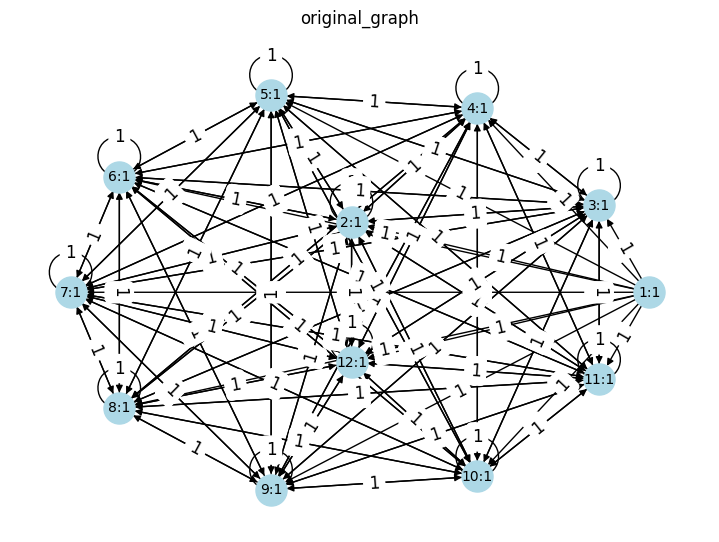

In [48]:
original_graph.visualise_short('original_graph')

In [52]:
validation_report = are_triplets_valid(original_graph, model)
validation_report

{'value': False,
 'description': "Invalid transition: The conversation flow is not logical. The user's response 'where can i contact them?' does not logically follow the assistant's question about returning the car. The transition between these messages is not coherent. Invalid transition: The conversation flow is not logical. The assistant's suggestion of a museum and the user's question about the cost of entering the museum do not have a direct connection. The assistant's response about the museum being free to enter seems out of context and does not naturally follow the user's question. Invalid transition: The conversation flow is not logical. The user's response about looking for attractions in London does not directly relate to the assistant's initial question about added insurance. The transition between these messages is not coherent. Invalid transition: The conversation flow is not logical. The assistant's initial question about insurance does not naturally lead to the user's r

Questionable description (example: "The assistant's suggestion of a museum and the user's question about the cost of entering the museum do not have a direct connection.")

Adding the second dialogue

In [49]:
additional_dialogue = [Dialogue.from_list(c) for c in [new_data[1]]]
additional_dialogue

[Dialogue(messages=[DialogueMessage(text='Hello! How can I help you?', participant='assistant'), DialogueMessage(text='I need to purchase tickets.', participant='user'), DialogueMessage(text='Where are you travelling? What date and time would you like to leave?Ho', participant='assistant'), DialogueMessage(text='I am going to LOng Beach on the 7th of March in the afternoon 3:15.', participant='user'), DialogueMessage(text='Where are you departing from?', participant='assistant'), DialogueMessage(text='I am departing from SD.', participant='user'), DialogueMessage(text='How many tickets will you need?', participant='assistant'), DialogueMessage(text='FOr 2 please.', participant='user'), DialogueMessage(text='You want 2 tickets to from Long Beach to San Diego on March 7th at 3:15 pm, correct?', participant='assistant'), DialogueMessage(text='Yes that is correct, is it a direct bus?', participant='user'), DialogueMessage(text='It is a direct trip, but that time is unavailable. How about 3

In [53]:
appender = AppendChain()
dialogues = original_dialogue + additional_dialogue
result_graph = appender.invoke(dialogues, original_graph)
result_graph

model:   gpt-3.5-turbo
LLM
'DialogueGraph' object has no attribute 'reason'


Graph(graph_dict={'edges': [{'source': 1, 'target': 2, 'utterances': ["i'm having a friend visit and we want some fun attractions to go to, maybe a museum. can you find one for me?"]}, {'source': 1, 'target': 3, 'utterances': ['please look for attractions in london, uk.']}, {'source': 1, 'target': 4, 'utterances': ['is there anything else? preferably something child-friendly.']}, {'source': 1, 'target': 5, 'utterances': ['where can i contact them?']}, {'source': 1, 'target': 6, 'utterances': ['is there a cost to enter the museum?']}, {'source': 1, 'target': 7, 'utterances': ["that's great. can you also find me a rental car? i'd like to pick it up by morning 11 and i need it next thursday."]}, {'source': 1, 'target': 8, 'utterances': ['i will be needing the car until the 10th of march.']}, {'source': 1, 'target': 9, 'utterances': ['yes, london is where i want to pick it up.']}, {'source': 1, 'target': 10, 'utterances': ['that works for me, please reserve the rental.']}, {'source': 1, 't

In [54]:
all_utterances_present(result_graph, dialogues)

{'it costs $24.00 a day.', 'for 2 please.', 'yes that would be great.', 'yes please rent the car.', 'i also need a rental car there.', 'yes that would be fine.', 'what else did you find?', 'that sounds good.', "no thanks, i don't need it.", 'yes that is correct, is it a direct bus?', 'i am departing from sd.', 'where are you travelling? what date and time would you like to leave?ho', 'how much is it daily?', 'i will return it on the 14th of this month.', 'i am going to long beach on the 7th of march in the afternoon 3:15.', 'i need to purchase tickets.'}
{'where are you travelling? what date and time would you like to leave?'}


False

In [55]:
validation_report = are_triplets_valid(result_graph, model)
validation_report

{'value': False,
 'description': "Invalid transition: The current transition is not logical. The assistant's response 'In which city should I search in?' does not naturally lead to the user's response about wanting to visit attractions. It would make more sense for the assistant to provide information about attractions or ask for more details about the user's preferences. Invalid transition: The conversation flow is not logical. The assistant's initial response suggests a museum called Apsley House, but the user's response asking for attractions in London does not directly connect to the assistant's next message, which repeats the suggestion of Apsley House. This creates a disjointed and repetitive conversation flow. Invalid transition: The conversation flow is not logical. The assistant's response about suggesting a museum does not naturally lead to the user's response about picking up a rental car in London. There is a disconnect in the conversation flow. Invalid transition: The conv

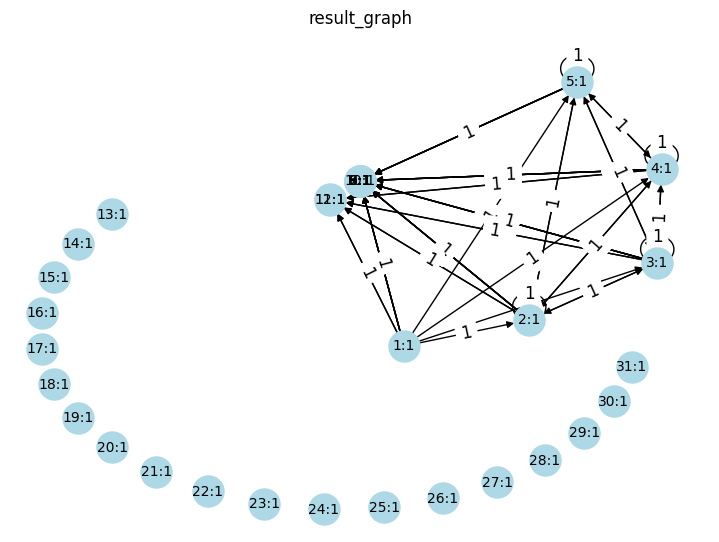

In [56]:
result_graph.visualise_short('result_graph')

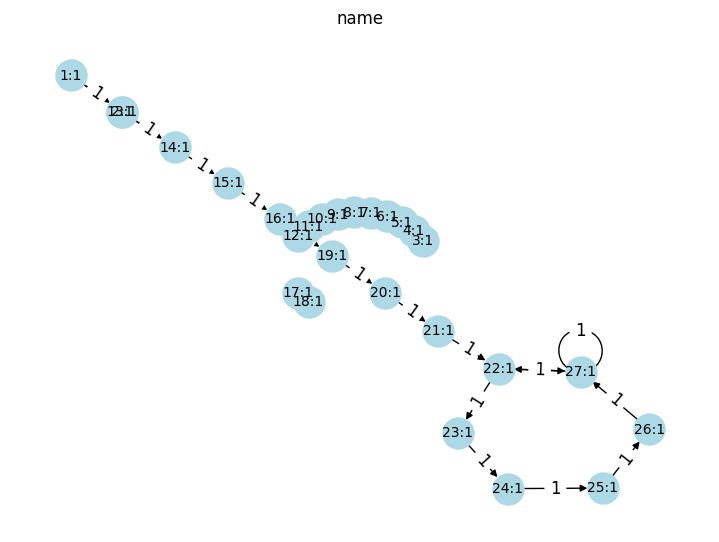

In [178]:
new_graph1.visualise_short('name')

Для будущего сравнения методов следует определить:
1. данные - датасет, объем выборки (общее количество примеров в выборке и количество диалогов для объединения в 1 граф), доп.требования к диалогам (количество и длина реплик, тема и т.д.)
2. метод для построения первого графа (ThreeStagesGraphGenerator/другой?)
3. модели (GENERATION_MODEL, COMPARE_MODEL, FORMATTER_MODEL, EMBEDDER_MODEL, RERANKER_MODEL)
3. метрики 

Метрики валидности графа:
- сейчас есть all_utterances_present, are_triplets_valid
- Transition Validation? (проверяет наличие логических противоречий в триплете, а также его совпадение с темой и контекстом диалога по смыслу)

Метрики сходства нового графа с исходным:
- is_same_structure, compare_graphs?

Количественные метрики:
- Edge thickness/другие?